In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
import cnn_base as base
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
from torchvision.datasets import ImageFolder
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
import time
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F

C:\Users\rongjoker\anaconda3\envs\pandas\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA']='1'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
data_dir = '../data/kaggle_leaves/classify-leaves/'
batch_size = 128

In [4]:
# train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
# test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [5]:
# train_data.iloc[0:4]

In [6]:
# len(train_data)

In [7]:
# test_data.iloc[0:4]

In [8]:
# train_data.groupby('label').count()

In [9]:
# train_data.describe()

In [10]:
# train_img_label, test_img_label = train_test_split(train_data, test_size=0.3, stratify=train_data.iloc[:, 1])

In [11]:
# train_img_label.describe()

In [12]:
# test_img_label.describe()

In [13]:
# train_img_label.head()

In [14]:
# # 将划分好的数据写入相应文件
# train_img_label.to_csv(os.path.join(data_dir, 'split_train.csv'), index=False)
# test_img_label.to_csv(os.path.join(data_dir, 'split_test.csv'), index=False)

In [15]:
# #@save
# def reorg_train_valid(img_label, train=True):
#     if train:
#         image_folder = 'train_image'
#     else:
#         image_folder = 'test_image'
        
#     split_image_folder = os.path.join(data_dir, image_folder)
#     print('split_image_folder:', split_image_folder)
#     if not os.path.exists(split_image_folder):
#         os.makedirs(split_image_folder)
    
#     for row in img_label.itertuples():
#         # 安装分类创建目录
#         image_label_folder = os.path.join(split_image_folder, row[2])        
#         img_path_ori = os.path.join(data_dir, row[1])
#         if not os.path.exists(image_label_folder):
#             os.makedirs(image_label_folder)  # makedirs 创建文件时如果路径不存在会创建这个路径
#         shutil.copy(img_path_ori, image_label_folder)

In [16]:
# reorg_train_valid(train_img_label, train=True)

In [17]:
# reorg_train_valid(train_img_label, train=False)

## 创建划分好的训练集和测试集、数据增强

In [18]:
# # 创建划分好的训练集和测试集
h_flip = transforms.RandomHorizontalFlip(p=0.5)
v_flip = transforms.RandomVerticalFlip(p=0.5)
shape_aug = transforms.RandomResizedCrop((224, 224), scale=(0.1, 1), ratio=(0.5, 2))
brightness_aug = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0)
train_augs = transforms.Compose([h_flip, v_flip])  # 图像增广
train_data_trans = transforms.Compose([transforms.Resize(224),
                                       train_augs,
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_trans = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [19]:
train_data = ImageFolder(os.path.join(data_dir, 'train_image'),
                         transform=train_data_trans, target_transform=None)
test_data = ImageFolder(os.path.join(data_dir, 'test_image'),
                        transform=test_data_trans, target_transform=None)

In [20]:
# 将ImageFolder的映射关系存到csv
id_code = pd.DataFrame(list(train_data.class_to_idx.items()),
                       columns=['label', 'id'])
id_code.to_csv(os.path.join(data_dir, 'id_code.csv'), index=False)

In [21]:
train_data.class_to_idx.items()

dict_items([('abies_concolor', 0), ('abies_nordmanniana', 1), ('acer_campestre', 2), ('acer_ginnala', 3), ('acer_griseum', 4), ('acer_negundo', 5), ('acer_palmatum', 6), ('acer_pensylvanicum', 7), ('acer_platanoides', 8), ('acer_pseudoplatanus', 9), ('acer_rubrum', 10), ('acer_saccharinum', 11), ('acer_saccharum', 12), ('aesculus_flava', 13), ('aesculus_glabra', 14), ('aesculus_hippocastamon', 15), ('aesculus_pavi', 16), ('ailanthus_altissima', 17), ('albizia_julibrissin', 18), ('amelanchier_arborea', 19), ('amelanchier_canadensis', 20), ('amelanchier_laevis', 21), ('asimina_triloba', 22), ('betula_alleghaniensis', 23), ('betula_jacqemontii', 24), ('betula_lenta', 25), ('betula_nigra', 26), ('betula_populifolia', 27), ('broussonettia_papyrifera', 28), ('carpinus_betulus', 29), ('carpinus_caroliniana', 30), ('carya_cordiformis', 31), ('carya_glabra', 32), ('carya_ovata', 33), ('carya_tomentosa', 34), ('castanea_dentata', 35), ('catalpa_bignonioides', 36), ('catalpa_speciosa', 37), ('ced

In [22]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [23]:
print('Train_data:')
print('Number of train_dataloader:\t', len(train_dataloader))  # 显示batch的数量
print('Number of train_dataset:\t', len(train_dataloader.dataset))  # 显示训练集样本总数量
print('Test_data:')
print('Number of test_dataloader:\t', len(test_dataloader))  # 显示batch的数量
print('Number of test_dataset:\t', len(test_dataloader.dataset))  # 显示测试集样本总数量
# 每个batch的数据形状
train_X, train_y = next(iter(train_dataloader))
print('Shape:')
print('The shape of train_features in a batch run:\t', train_X.shape)
print('The shape of train_labels in a batch run:\t', train_y.shape, '\n')

Train_data:
Number of train_dataloader:	 101
Number of train_dataset:	 12847
Test_data:
Number of test_dataloader:	 101
Number of test_dataset:	 12847
Shape:
The shape of train_features in a batch run:	 torch.Size([128, 3, 224, 224])
The shape of train_labels in a batch run:	 torch.Size([128]) 



In [24]:
# # 绘制Epoch级图像函数
def report_plot_epoch(num_epochs, report_epoch):
    # 更新训练损失、训练准确度、测试损失、测试准确度图像
    # 转置一下report列表
    report_epoch_t = list(map(list, zip(*report_epoch)))

    plt.close('all')

    # 绘制第一张子图
    loss_plot = plt.subplot(2, 1, 1)
    loss_plot.plot(report_epoch_t[0], report_epoch_t[1],
                   color='tab:blue', label='train_loss')
    loss_plot.plot(report_epoch_t[0], report_epoch_t[3],
                   color='tab:orange', label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim(1, num_epochs)
    # plt.ylim(0, 1)
    plt.xticks(range(1, num_epochs + 1, math.ceil(num_epochs / 10)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()

    # 绘制第二张子图
    acc_plot = plt.subplot(2, 1, 2)
    acc_plot.plot(report_epoch_t[0], report_epoch_t[2],
                  color='tab:blue', label='train_acc')
    acc_plot.plot(report_epoch_t[0], report_epoch_t[4],
                  color='tab:orange', label='test_acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.xlim(1, num_epochs)
    plt.ylim(0, 1)
    plt.xticks(range(1, num_epochs + 1, math.ceil(num_epochs / 10)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()

    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.pause(0.1)  # 图片停留0.1s


# # 绘制Batch级图像函数
def report_plot_batch(num_epochs, report_batch, report_epoch):
    # 更新训练损失、训练准确度、测试损失、测试准确度图像
    # 转置一下report列表
    report_batch_t = list(map(list, zip(*report_batch)))
    report_epoch_t = list(map(list, zip(*report_epoch)))

    plt.close('all')

    # 绘制第一张子图
    loss_plot = plt.subplot(2, 1, 1)
    loss_plot.plot(report_batch_t[0], report_batch_t[1],
                   color='tab:blue', label='train_loss')
    if not report_epoch_t == []:
        loss_plot.plot(report_epoch_t[0], report_epoch_t[3],
                       color='tab:orange', label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim(0, num_epochs)
    # plt.ylim(0, 1)
    plt.xticks(range(0, num_epochs + 1, math.ceil(num_epochs / 10)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()

    # 绘制第二张子图
    acc_plot = plt.subplot(2, 1, 2)
    acc_plot.plot(report_batch_t[0], report_batch_t[2],
                  color='tab:blue', label='train_acc')
    if not report_epoch_t == []:
        acc_plot.plot(report_epoch_t[0], report_epoch_t[4],
                      color='tab:orange', label='test_acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.xlim(0, num_epochs)
    plt.ylim(0, 1)
    plt.xticks(range(0, num_epochs + 1, math.ceil(num_epochs / 10)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()

    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.pause(0.1)  # 图片停留0.1s

## 定义模型、损失函数、优化器，并执行训练

<font color='red'> 定义累加器类和记录多次运行时间的Timer类（来自d2l）</font>

In [25]:
# # 定义累加器的类，用于累加每个batch的运行状态数据（损失和准确度）
class Accumulator:
    """在n个变量上累加"""

    def __init__(self, n):  # 初始化，n为累加器的列数
        self.data = [0.0] * n  # list * int 意思是将数组重复 int 次并依次连接形成一个新数组

    def add(self, *args):  # data和args对应列累加
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):  # 重置
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):  # 索引
        return self.data[idx]


# # 定义记录多次运行时间的Timer类
class Timer:
    """记录多次运行时间"""

    def __init__(self):
        """初始化"""
        self.tik = None
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并在列表中记录时间"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间的总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

<font color='red'> 定义测试函数</font>

In [26]:
# # 计算一个batch中预测正确的个数
# 将预测值y_hat与真实值y进行比较，获取预测正确的个数
# accuracy_num返回的结果除以len(y)，则为准确率
def accurate_num(y_hat, y):
    """计算预测正确的数量"""
    # 这里的y_hat的行数为样本数，列数为分类数，即一行表示某个样本的计算结果（经过softmax后每行所有元素的和都为1）
    # y是1维向量，元素的个数对应样本数
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:  # 判断检查y_hat是一个矩阵
        y_hat = y_hat.argmax(axis=1)  # 获取每一行最大元素值的下标，即预测的分类的类别
    cmp = y_hat.type(y.dtype) == y  # 将y_hat转变为y的数据类型，然后作比较，cmp为布尔类型
    return float(cmp.type(y.dtype).sum())


# # 计算准确率
# 对于任意数据迭代器dataloader可访问的数据集，评估在任意模型上的准确率
# 实际上是计算一个epoch中的准确率
def evaluate_accuracy(test_dataloader, model, device):
    """计算在指定数据集上模型的精度"""
    if isinstance(model, torch.nn.Module):  # 判断检查model是不是torch.nn.Module类型
        model.eval()  # 将模型设置为评估模式

    # 实例化Accumulator对象，用于存储测试过程中的状态数据
    metric = Accumulator(3)  # 实例化Accumulator对象，累加器列数为3，测试损失总和、测试准确度总和、样本数

    # 执行测试
    with torch.no_grad():  # 不计算梯度，只前向传播
        for X, y in test_dataloader:  # 使用dataloader配合for循环,遍历每个batch
            # 将X，y放入GPU
            if isinstance(X, list):  # 如果X是list类型则按元素移至GPU
                X = [x.to(device) for x in X]
            else:  # 如果X是tensor类型则一次全部移动至GPU
                X = X.to(device)
            y = y.to(device)
            # 计算预测值
            y_hat = model(X)
            # 计算损失
            loss_value = loss_fun(y_hat, y)
            # 将（batch)测试损失总和、（batch)测试准确个数、（batch)样本数放入累加器
            metric.add(float(loss_value.sum()), accurate_num(y_hat, y), y.numel())
    # 返回测试损失和测试精度
    return metric[0] / metric[2], metric[1] / metric[2]

<font color='red'> 定义训练函数
之前的模板中，采用了d2l中第3章定义的训练函数（已改为GPU计算）<br><br>
本模板中，改用为d2l中第6章定义的训练函数，主要区别包括：<br>
1.d2l包中的训练计时功能，能够反映程序运行的时间<br>
2.增加了batch级的绘图<br>
3.每个Epoch都会将迭代报告存储至相应的csv<br>
4.训练结束后会保存模型<br>
5.每个Epoch都会将当前模型保存至新建的model_params_epoch文件夹中（训练函数中，默认被注释，占用硬盘空间）</font>

In [27]:
def train_from_scratch_main(model, train_dataloader, test_dataloader, num_epochs, loss_fun, optimizer, device, model_path):
    """在GPU中训练模型"""
    # 定义存储训练损失、训练精度、测试损失、测试精度的列表
    report_epoch = []  # Epoch级的报告,一个epoch占用一行
    report_batch = []  # Batch级的报告，一个batch占用一行，但不是每一个batch都有，仅包含训练损失、训练精度

    # Xavier Uniform模型初始化，在每一层网络保证输入和输出的方差相同
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    model.apply(init_weights)  # 应用Xavier Uniform初始化

    model=model.to(device)  # 将模型放入GPU

    timer, num_batches = Timer(), len(train_dataloader)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2)

    #  执行每个epoch的训练，得到当前epoch的训练损失和训练精度
    for epoch in range(num_epochs):
        # 打印Epoch状态
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print("learning rate:", optimizer.param_groups[0]['lr'])
        # 将模型设置为训练模式
        model.train()  # 将模型设置为训练模式

        # 实例化Accumulator对象，用于存储训练过程中的状态数据
        metric = Accumulator(3)  # 实例化Accumulator对象，累加器列数为3，训练损失总和、训练准确度总和、样本数

        # 执行每一个batch的训练
        for batch, (X, y) in enumerate(train_dataloader):  # 使用dataloader配合for循环，遍历每个batch
            timer.start()  # 开启定时器
            X, y = X.to(device), y.to(device)  # 将X， y移动至GPU
            # 计算预测值
            y_hat = model(X)
            # 计算损失
            loss_value = loss_fun(y_hat, y)
            # 计算梯度并更新预测值
            if isinstance(optimizer, torch.optim.Optimizer):  # 判断检查updater是否为torch.nn.Module类型
                """使用PyTorch内置的优化器和损失函数"""
                # 清除梯度
                optimizer.zero_grad()
                # 反向传播（计算梯度）
                loss_value.mean().backward()  # 计算整个batch中的损失平均值，mean()与交叉熵中reduction='none'有关
                # 更新参数
                optimizer.step()
            else:
                """使用定制的优化器和损失函数"""
                pass

            with torch.no_grad():
                # 将（batch)训练损失总和、（batch)训练准确度总和、（batch)样本数放入累加器
                metric.add(float(loss_value.sum()), accurate_num(y_hat, y), y.numel())

            timer.stop()  # 关闭定时器

            # 计算一个batch训练loss和accuracy
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]

            num_batches = len(train_dataloader)
            # %取模:返回除法的余数  //取整除:取商的整数部分
            if (batch + 1) % (num_batches // 5) == 0 or batch == num_batches - 1:
                # 存储至Batch级的报告
                report_batch.append([epoch + (batch + 1) / num_batches, train_loss, train_acc])
                # Batch级绘图
                report_plot_batch(num_epochs, report_batch, report_epoch)

        # 利用测试集，评估当前模型，返回当前epoch的测试损失和测试精度
        test_loss, test_acc = evaluate_accuracy(test_dataloader, model, device)

        scheduler.step()

        # 打印Epoch级的报告
        print('train_loss:', train_loss, '\ttrain_acc', train_acc)
        print('test_loss:', test_loss, '\ttest_acc', test_acc)
        print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
              f'on {str(device)}')

        # # 存储至Epoch级的报告
        report_epoch.append([epoch + 1, train_loss, train_acc, test_loss, test_acc])
        report_plot_batch(num_epochs, report_batch, report_epoch)

        # 每个Epoch将报告存储至相应csv文件中(路径：/save/文件名.csv)
        save_path = os.path.join(data_dir, 'save')
        print(os.path.exists(save_path))
        if not os.path.exists(save_path):
            os.makedirs(save_path)  # makedirs 创建文件时如果路径不存在会创建这个路径
        pd.DataFrame(columns=["epoch", "train_loss", "train_acc", "test_loss", "test_acc"],
                     data=report_epoch).to_csv(save_path + "/report_epoch.csv", index=False)
        pd.DataFrame(columns=["epoch", "train_loss", "train_acc"],
                     data=report_batch).to_csv(save_path + "/report_batch.csv", index=False)
        print("report was saved\n")

        # # 保存每个Epoch的模型参数至文件(路径：/save/model_params_epoch下)
        epoch_params_file_path = os.path.join(save_path, 'model_params_epoch')
        if not os.path.exists(epoch_params_file_path):
            os.makedirs(epoch_params_file_path)  # makedirs 创建文件时如果路径不存在会创建这个路径
        # epoch_params_file = os.path.join(epoch_params_file_path, 'epoch%d_params.pth' % (epoch + 1))
        epoch_state = {'model_params': model.state_dict(),
                       'optimizer_params': optimizer.state_dict(),
                       'epoch': epoch + 1}
        torch.save(epoch_state, epoch_params_file_path + '/epoch%d_params.pth' % (epoch + 1))
        print("model_params_epoch was saved\n")

        # Epoch级绘图
        report_plot_epoch(num_epochs, report_epoch)
    torch.save(model.state_dict(), model_path)

In [28]:
def train_concise_main(net, train_iter, valid_iter,loss, num_epochs, lr, wd, lr_period,
          lr_decay):
    # optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
    #                           weight_decay=wd)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = net.to(d2l.try_gpu())
    # net = net.to('cpu')
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, optimizer, d2l.try_all_gpus())
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(d2l.try_all_gpus())}')

<font color='red'>定义模型、损失函数、优化器，并执行训练</font>

In [29]:
# # # 定义超参数
# learning_rate = 1e-4
# batch_size = 128
# num_epochs = 300
# weight_decay = 1e-3

In [30]:
def train_concise():
    # base.ResNet18().layer_summary((1, 3, 224, 224))
    learning_rate = 1e-4
    model = base.ResNet18(lr=learning_rate, num_classes=176)
    print(d2l.try_all_gpus())
    # print(model)
    loss = nn.CrossEntropyLoss(reduction='none')
    wd ,lr_period, lr_decay =  5e-4, 4, 0.9
    # # 定义优化器
    # 实例化SGD实例
    # # 执行训练
    print(f'-------------------------------\n'
          f'Train model\n'
          f'-------------------------------')
    print('Start time:', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))  # 打印按指定格式排版的时间
    train_concise_main(model, train_dataloader, test_dataloader,loss, 10, learning_rate, wd ,lr_period, lr_decay)
    print('End time:', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))  # 打印按指定格式排版的时间
    torch.save(model.state_dict(), 'model/leaves_resnet_jupyter.pth')


train loss 0.789, train acc 0.776, valid acc 0.778
612.6 examples/sec on [device(type='cuda', index=0)]
End time: 2023-10-07 00:20:07


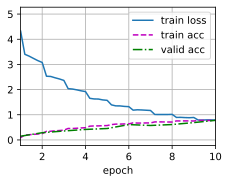

In [31]:
train_concise()

In [32]:
def infer(pred_iter):
    learning_rate = 1e-4
    model = base.ResNet18(lr=learning_rate, num_classes=176)
    model.load_state_dict(torch.load('model/leaves_resnet_jupyter.pth'))
    model = model.to(try_gpu())
    model.eval()  # 设置模型为推理模式
    prediction = []
    for index, X in enumerate(pred_iter):
        X = X.to('cuda:0')
        prediction.extend(train_labels_header[net(X).argmax(1).cpu()])
    test_data['label'] = prediction
    test_data.to_csv(os.path.join(data_dir, 'submission.csv'), index=None)

In [ ]:
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))
pred_images = test_data.iloc[:, 0].values
pred_iter = load_data(pred_images, None, 256, train=False)